In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m26_prob_1 import MultiDecoderCondVAE
from loss.l26oss_all import integrated_loss_fn


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/pre_retrain_loader.pt',weights_only=False)
val_loader = torch.load('torch/pre_reval_loader.pt',weights_only=False)
test_loader = torch.load('torch/pre_retest_loader.pt',weights_only=False)


In [5]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]
x_dim,c_dim

(23, 15)

In [6]:
model = MultiDecoderCondVAE(x_dim,c_dim,z_dim=8).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)

In [7]:
history = {'train_loss':[],'train_bce':[],'train_mse':[],'train_kl':[],'val_loss':[],'val_bce':[],'val_mse':[],'val_kl':[]}
epochs = 600

In [8]:
for epoch in range(1,epochs+1):
    model.train()
    t_loss,t_mse,t_bce,t_kl = 0,0,0,0
    for x,c in train_loader:
        x,c = x.to(device),c.to(device)
        optimizer.zero_grad()
        bce_logit,binary_out,x_hat,z_mu,z_logvar = model(x,c)
        loss_dict = integrated_loss_fn(bce_logit,x_hat, x,z_mu,z_logvar)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
        t_mse +=loss_dict['mse_loss'].item()
        t_bce +=loss_dict['bce_loss'].item()
        t_kl +=loss_dict['kl_loss'].item()

    model.eval()
    v_loss,v_mse,v_bce,v_kl = 0,0,0,0
    x_true_all,x_pred_all,x_hat_all = [],[],[]
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_bce_logit,v_binary_out,v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            loss_dict = integrated_loss_fn(v_bce_logit, v_x_hat, v_x,v_mu,v_logvar)
            v_loss += loss_dict['loss'].item()
            v_mse += loss_dict['mse_loss'].item()
            v_bce += loss_dict['bce_loss'].item()
            v_kl += loss_dict['kl_loss'].item()
            x_true = v_x
            x_true_all.extend(x_true.cpu().numpy())
            x_pred_all.extend(v_binary_out.cpu().numpy())
            x_hat_all.extend(v_x_hat.cpu().numpy())
    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_mse'].append(t_mse/len(train_loader))
    history['train_bce'].append(t_bce/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_mse'].append(v_mse/len(val_loader))
    history['val_bce'].append(v_bce/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break


Epoch [2/600]|Train:3.7312 |Val:3.4817
Epoch [20/600]|Train:1.5145 |Val:1.7360
EarlyStopping counter: 1 out of 40
Epoch [40/600]|Train:0.9263 |Val:1.1393
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [60/600]|Train:0.7150 |Val:0.9865
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
Epoch [80/600]|Train:0.6123 |Val:0.8940
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of

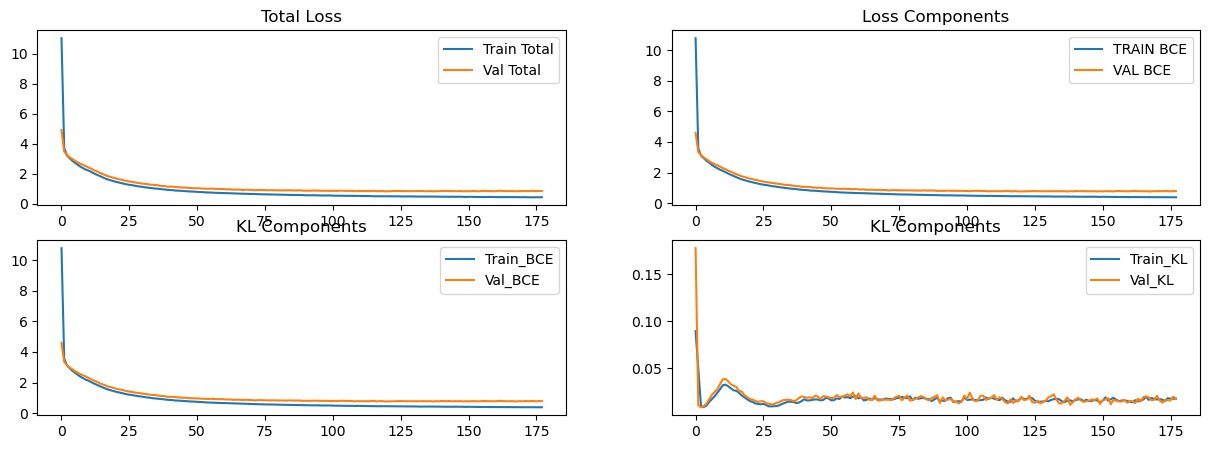

In [12]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history['train_bce'],label ='Train_BCE')
plt.plot(history['val_bce'], label = 'Val_BCE')
plt.title('KL Components')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

In [13]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
x_scaler = joblib.load('torch/abs_x_scaler.pkl')

In [55]:
for i,index in enumerate(test_loader):
    x,c = index
print(x)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1834, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1379, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500,
         0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
early_stopping.load_best_model(model)
model.eval()

x_true = []
x_pred = []
## 최적의 model의 z리스트와 라벨 리스트
z_list = []
with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)

        bce_logit,binary_out, x_hat,z_mu,z_logvar = model(x_t,c_t)
        h = model.encoder(torch.concat([x_t,c_t],axis = 1))
        mu = model.mu_head(h)
        z_list.append(mu.numpy())
        
        x_true.append(x_t.cpu().numpy())
        x_pred.append(x_hat.cpu().numpy())
all_x_true = np.vstack(x_true)
all_x_hat = np.vstack(x_pred)
z_values_all = np.concatenate(z_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

Restored best model with loss: 0.823627


## pca 구하기

In [39]:
test_loader = torch.load('torch/pre_retest_loader.pt',weights_only=False)

데이터 추출 및 잠재 공간 수집 시작...
Restored best model with loss: 0.823627
현재 처리 중: Loader 1/19
현재 처리 중: Loader 5/19
현재 처리 중: Loader 10/19
현재 처리 중: Loader 15/19
전체 수집된 데이터 포인트: 1182개
PCA 차원 축소 실행 중...


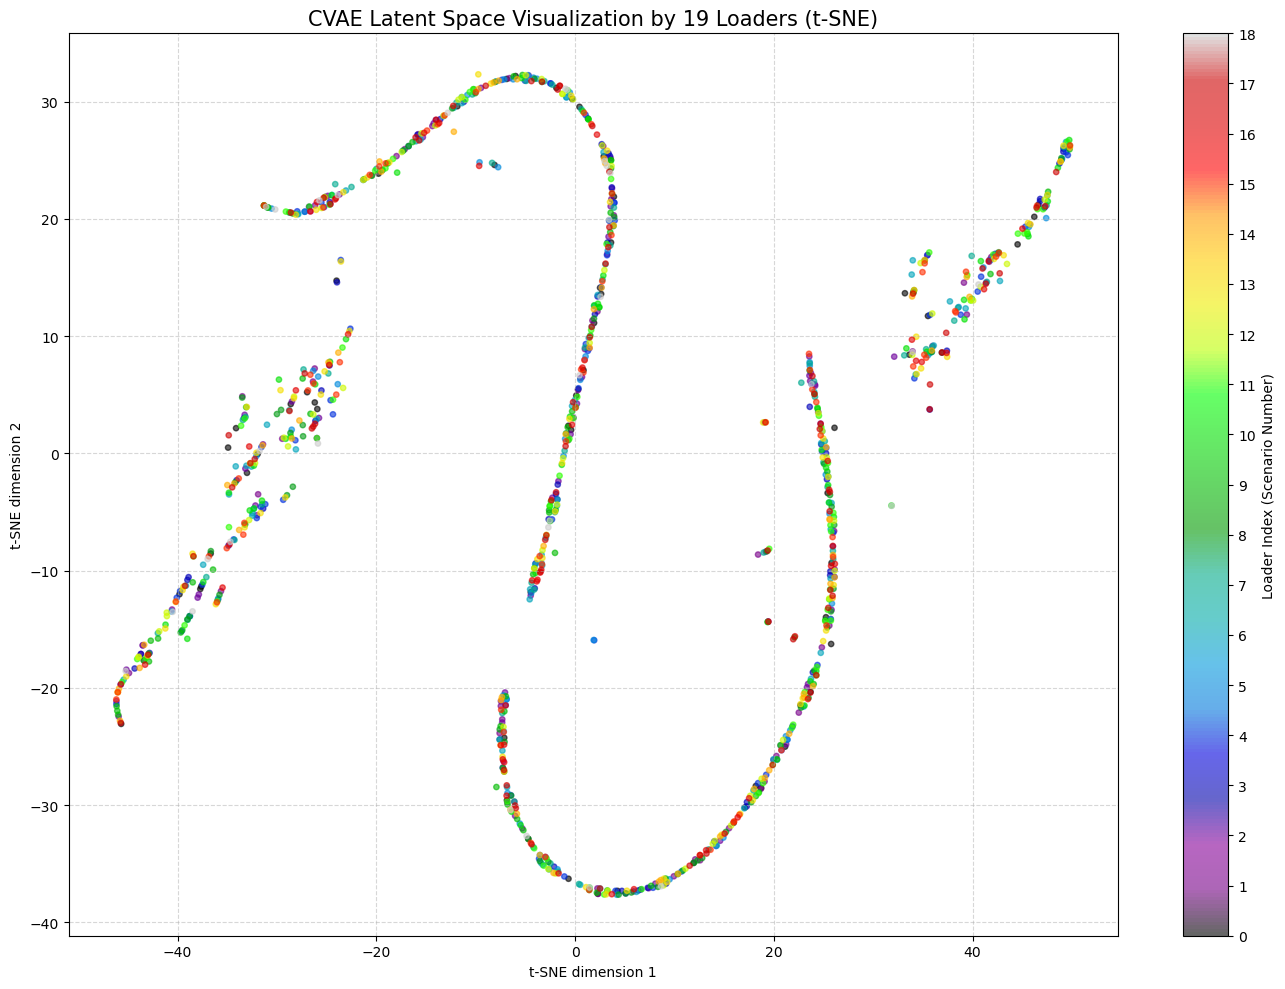

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

loaders = [(f'test_laoder_{i}') for i in range(1,20)]
z_list = []
label_list = []

print("데이터 추출 및 잠재 공간 수집 시작...")
early_stopping.load_best_model(model)
model.eval() # 평가 모드 설정
with torch.no_grad():
    for loader_idx, loader in enumerate(test_loader):
        # 로더별 처리 상황 출력
        if (loader_idx + 1) % 5 == 0 or loader_idx == 0:
            print(f"현재 처리 중: Loader {loader_idx + 1}/19")
            
        x_t, c_t =loader
        x_t, c_t = x_t.to(device), c_t.to(device)

        # CVAE 인코더를 통해 특징(mu) 추출
        # x_t와 c_t를 합쳐서 인코더에 입력 (모델 구조에 맞게 조정)
        inputs = torch.cat([x_t, c_t], dim=1)
        h = model.encoder(inputs)
        mu = model.mu_head(h)
        
        # GPU 데이터를 CPU로 옮기고 numpy로 변환
        z_list.append(mu.cpu().numpy())
        
        # 현재 로더의 인덱스를 라벨로 저장 (batch 크기만큼)
        batch_size = x_t.size(0)
        label_list.append(np.full(batch_size, loader_idx))

# 2. 데이터 통합
z_values_all = np.concatenate(z_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

print(f"전체 수집된 데이터 포인트: {z_values_all.shape[0]}개")

# 3. PCA 모델 생성 및 차원 축소 (고차원 -> 2차원)
print("TSNE 차원 축소 실행 중...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
z_viz = tsne.fit_transform(z_values_all)

# 4. 시각화
plt.figure(figsize=(14, 10))

# 19개를 구분하기 좋은 컬러맵(nipy_spectral) 사용
scatter = plt.scatter(z_viz[:, 0], z_viz[:, 1], 
                      c=all_labels, 
                      cmap='nipy_spectral', 
                      alpha=0.6, 
                      s=15)

# 컬러바 설정 (0~18번 로더 표시)
cbar = plt.colorbar(scatter, ticks=range(19))
cbar.set_label('Loader Index (Scenario Number)')

plt.title('CVAE Latent Space Visualization by 19 Loaders (t-SNE)', fontsize=15)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

loaders = [(f'test_laoder_{i}') for i in range(1,20)]
z_list = []
label_list = []

print("데이터 추출 및 잠재 공간 수집 시작...")
early_stopping.load_best_model(model)
model.eval() # 평가 모드 설정
with torch.no_grad():
    for loader_idx, (x_t,c_t) in enumerate(test_loader):
        # 로더별 처리 상황 출력
        if (loader_idx + 1) % 5 == 0 or loader_idx == 0:
            print(f"현재 처리 중: Loader {loader_idx + 1}/19")

        for x_t, c_t in (x_t,c_t):
            x_t.to(device), c_t.to(device)

            # CVAE 인코더를 통해 특징(mu) 추출
            # x_t와 c_t를 합쳐서 인코더에 입력 (모델 구조에 맞게 조정)
            inputs = torch.cat([x_t, c_t], dim=1)
            h = model.encoder(inputs)
            mu = model.mu_head(h)
            
            # GPU 데이터를 CPU로 옮기고 numpy로 변환
            z_list.append(mu.cpu().numpy())
            
            # 현재 로더의 인덱스를 라벨로 저장 (batch 크기만큼)
            batch_size = x_t.size(0)
            label_list.append(np.full(batch_size, loader_idx))

# 2. 데이터 통합
z_values_all = np.concatenate(z_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

print(f"전체 수집된 데이터 포인트: {z_values_all.shape[0]}개")

# 3. PCA 모델 생성 및 차원 축소 (고차원 -> 2차원)
print("PCA 차원 축소 실행 중...")
pca = PCA(n_components=2)
z_viz = pca.fit_transform(z_values_all)

# 4. 시각화 (19개 로더 구분)
plt.figure(figsize=(14, 10))

# 19개를 구분하기 좋은 컬러맵(nipy_spectral) 사용
scatter = plt.scatter(z_viz[:, 0], z_viz[:, 1], 
                      c=all_labels, 
                      cmap='nipy_spectral', 
                      alpha=0.6, 
                      s=15)

# 컬러바 설정 (0~18번 로더 표시)
cbar = plt.colorbar(scatter, ticks=range(19))
cbar.set_label('Loader Index (Scenario Number)')

plt.title('CVAE Latent Space Visualization by 19 Loaders (PCA)', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, linestyle='--', alpha=0.5)

# 범례가 너무 많으므로 그래프 옆에 작게 표시하거나 컬러바로 대체합니다.
plt.tight_layout()
plt.show()

데이터 추출 및 잠재 공간 수집 시작...
Restored best model with loss: 0.823627
현재 처리 중: Loader 1/19


ValueError: too many values to unpack (expected 2)

In [63]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

loaders = [(f'test_laoder_{i}') for i in range(1,20)]
z_list = []
label_list = []

print("데이터 추출 및 잠재 공간 수집 시작...")
early_stopping.load_best_model(model)
model.eval() # 평가 모드 설정
with torch.no_grad():
    for loader_idx, loader_1 in enumerate(test_loader):
        # 로더별 처리 상황 출력
        if (loader_idx + 1) % 5 == 0 or loader_idx == 0:
            print(f"현재 처리 중: Loader {loader_idx + 1}/19")
            
        for x_t, c_t in loader_1:
            x_t, c_t = x_t.to(device), c_t.to(device)

            # CVAE 인코더를 통해 특징(mu) 추출
            # x_t와 c_t를 합쳐서 인코더에 입력 (모델 구조에 맞게 조정)
            inputs = torch.cat([x_t, c_t], dim=1)
            h = model.encoder(inputs)
            mu = model.mu_head(h)
            
            # GPU 데이터를 CPU로 옮기고 numpy로 변환
            z_list.append(mu.cpu().numpy())
            
            # 현재 로더의 인덱스를 라벨로 저장 (batch 크기만큼)
            batch_size = x_t.size(0)
            label_list.append(np.full(batch_size, loader_idx))

# 2. 데이터 통합
z_values_all = np.concatenate(z_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

print(f"전체 수집된 데이터 포인트: {z_values_all.shape[0]}개")

# 3. PCA 모델 생성 및 차원 축소 (고차원 -> 2차원)
print("PCA 차원 축소 실행 중...")
pca = PCA(n_components=2)
z_viz = pca.fit_transform(z_values_all)

# 4. 시각화 (19개 로더 구분)
plt.figure(figsize=(14, 10))

# 19개를 구분하기 좋은 컬러맵(nipy_spectral) 사용
scatter = plt.scatter(z_viz[:, 0], z_viz[:, 1], 
                      c=all_labels, 
                      cmap='nipy_spectral', 
                      alpha=0.6, 
                      s=15)

# 컬러바 설정 (0~18번 로더 표시)
cbar = plt.colorbar(scatter, ticks=range(19))
cbar.set_label('Loader Index (Scenario Number)')

plt.title('CVAE Latent Space Visualization by 19 Loaders (PCA)', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, linestyle='--', alpha=0.5)

# 범례가 너무 많으므로 그래프 옆에 작게 표시하거나 컬러바로 대체합니다.
plt.tight_layout()
plt.show()

데이터 추출 및 잠재 공간 수집 시작...
Restored best model with loss: 0.823627
현재 처리 중: Loader 1/19


ValueError: too many values to unpack (expected 2)

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. 로더 리스트 수동 생성 (가장 안전한 방법)
# 변수명에 0이 붙는지(test_loader_01) 안 붙는지(test_loader_1) 꼭 확인하세요!
try:
    loaders = [(f'test_loader_{i}') for i in range(1, 20)]
except NameError:
    # 01, 02 형태일 경우를 위한 대비
    loaders = [eval(f'test_loader_{i:02d}') for i in range(1, 20)]

z_list = []
label_list = []

print("데이터 추출 시작...")
model.eval()

with torch.no_grad():
    for loader_idx, loader in enumerate(loaders):
        if (loader_idx + 1) % 5 == 0 or loader_idx == 0:
            print(f"현재 처리 중: Loader {loader_idx + 1}/19")
            
        for batch in loader:
            # [수정 포인트] 데이터가 몇 개든 상관없이 앞의 두 개만 가져옵니다.
            # batch[0] -> x_t, batch[1] -> c_t
            x_t = batch[0]
            c_t = batch[1]

            # CVAE 인코더 특징 추출
            # 모델의 입력 차원(concat)에 맞춰 결합
            inputs = torch.cat([x_t, c_t], dim=1)
            h = model.encoder(inputs)
            mu = model.mu_head(h)
            
            z_list.append(mu.cpu().numpy())
            label_list.append(np.full(x_t.size(0), loader_idx))

# 2. 데이터 통합 및 PCA
print("PCA 차원 축소 중...")
z_values_all = np.concatenate(z_list, axis=0)
all_labels = np.concatenate(label_list, axis=0)

pca = PCA(n_components=2)
z_viz = pca.fit_transform(z_values_all)

# 3. 시각화
plt.figure(figsize=(12, 9))
scatter = plt.scatter(z_viz[:, 0], z_viz[:, 1], 
                      c=all_labels, 
                      cmap='nipy_spectral', 
                      alpha=0.6, s=10)

cbar = plt.colorbar(scatter, ticks=range(19))
cbar.set_label('Loader Index (0-18)')

# 주성분 설명력 계산
var_ratio = pca.explained_variance_ratio_
plt.title(f'PCA Latent Space (PC1:{var_ratio[0]:.1%}, PC2:{var_ratio[1]:.1%})', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()

데이터 추출 시작...
현재 처리 중: Loader 1/19


IndexError: string index out of range

PCA 실행 중...


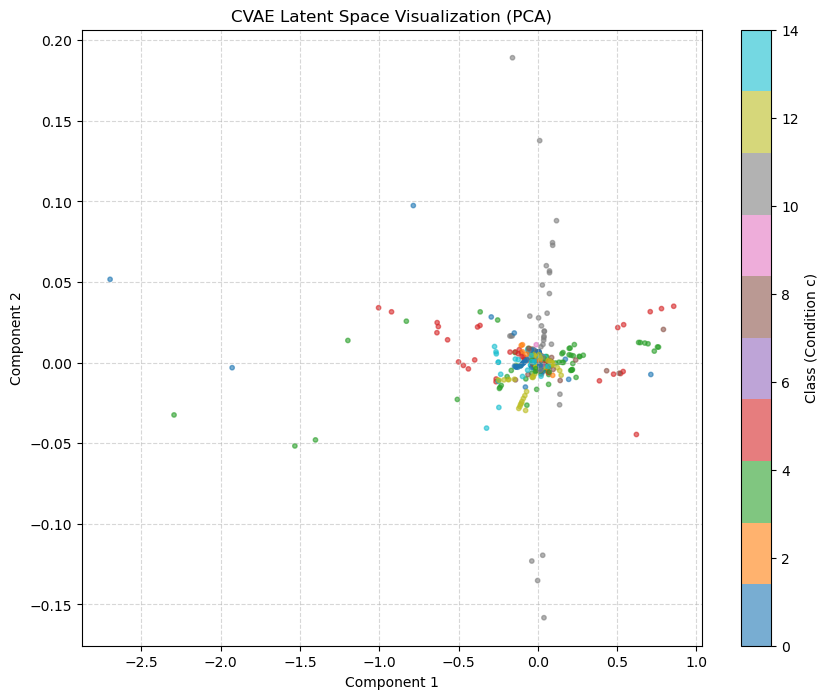

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 설정: PCA는 빠르고, t-SNE는 군집을 더 예쁘게 보여주지만 느립니다.
use_tsne = False 

z_viz = z_values_all
if z_values_all.shape[1] > 2:
    if use_tsne:
        print("t-SNE 실행 중... (시간이 다소 소요될 수 있습니다)")
        reducer = TSNE(n_components=2, random_state=42)
    else:
        print("PCA 실행 중...")
        reducer = PCA(n_components=2)
    z_viz = reducer.fit_transform(z_values_all)

# 시각화 실행
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_viz[:, 0], z_viz[:, 1], 
                      c=all_labels, # 모아둔 라벨 사용
                      cmap='tab10', 
                      alpha=0.6, 
                      s=10)

plt.colorbar(scatter, label='Class (Condition c)')
plt.title(f'CVAE Latent Space Visualization ({"t-SNE" if use_tsne else "PCA"})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [29]:
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_hat_raw = x_scaler.inverse_transform(all_x_hat)

In [30]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = all_x_true.flatten()
x_pred = all_x_hat.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
history = {'RMSE':round(float(rmse),4),'R2':round(float(r2),4)}

In [31]:
import json

save_path = "pre_re_prob_metrics.json"

with open(save_path, 'w') as f:
    # float 타입 데이터도 json.dump를 통해 안전하게 저장됩니다.
    json.dump(history, f, indent=4)

print(f"숫자 형태로 {save_path}에 저장 완료!")

숫자 형태로 pre_re_prob_metrics.json에 저장 완료!


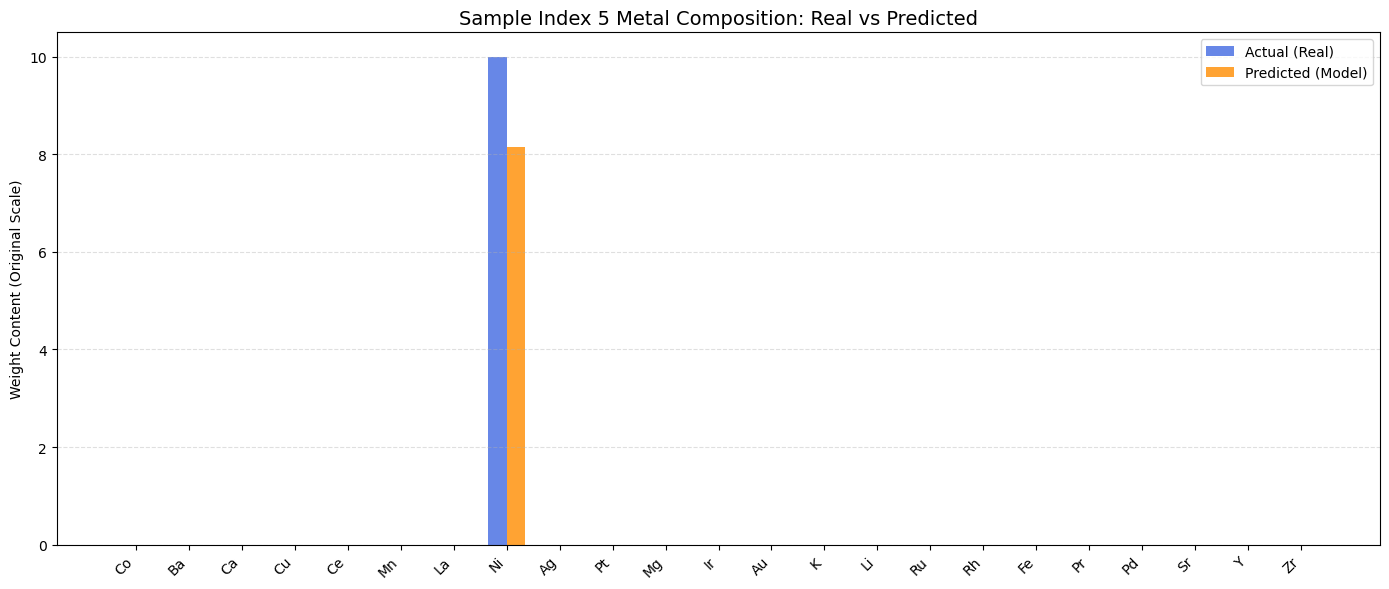

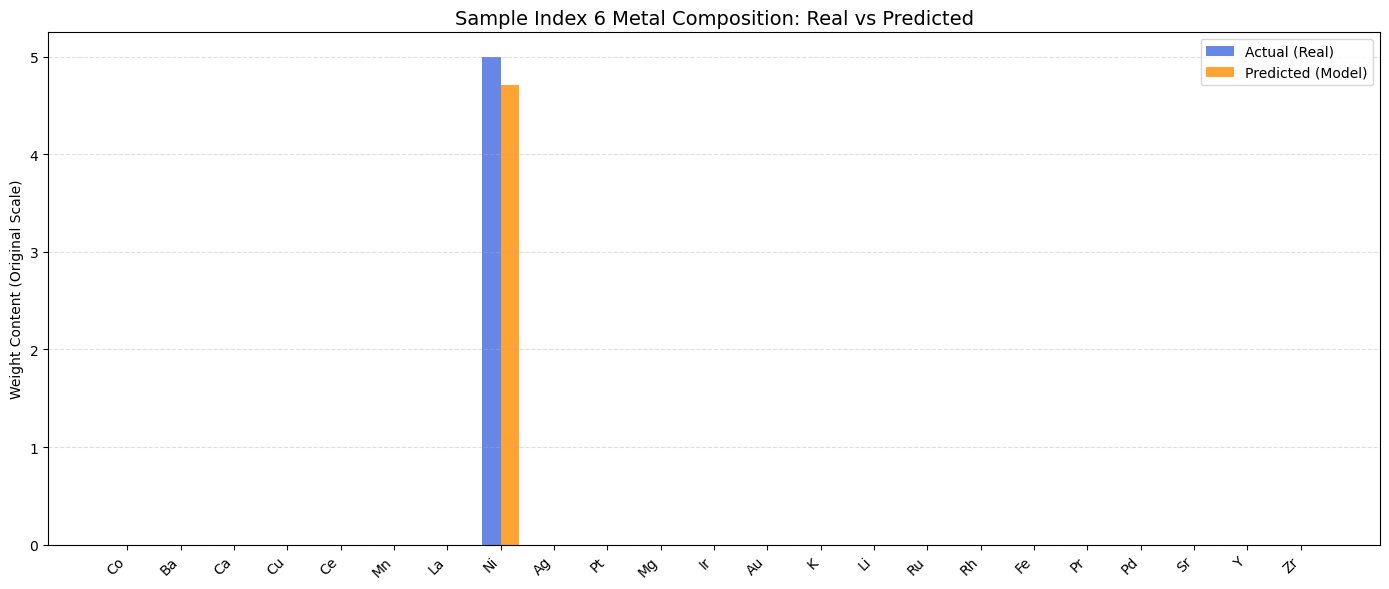

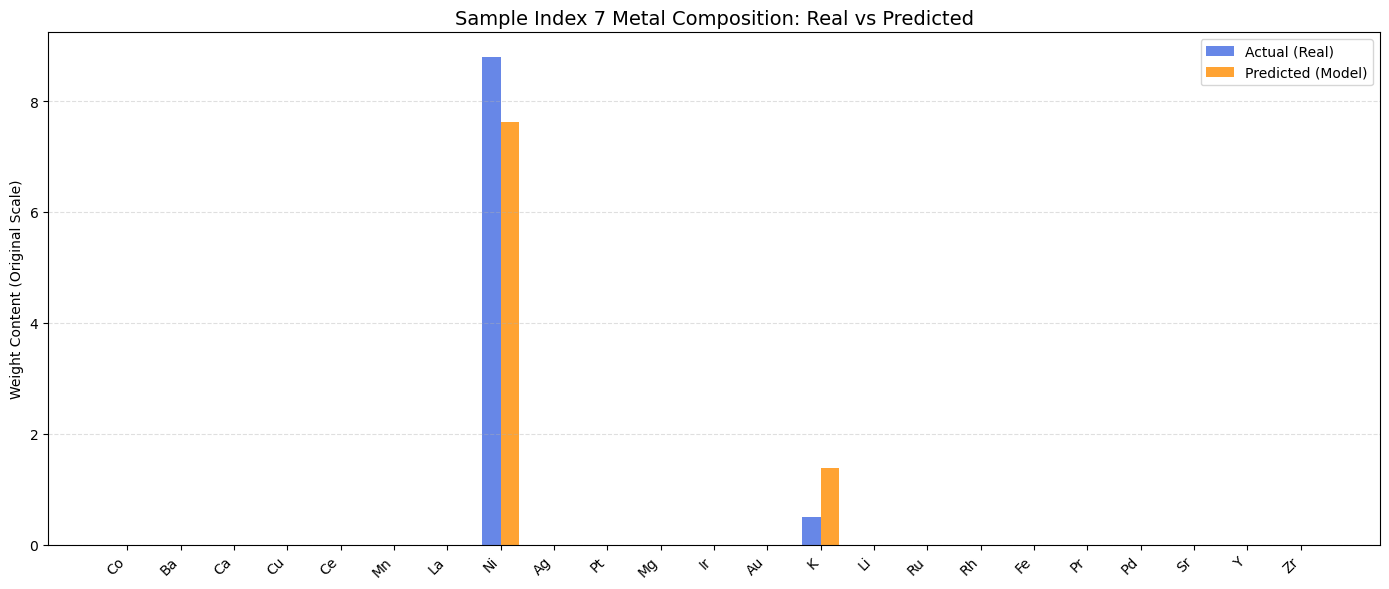

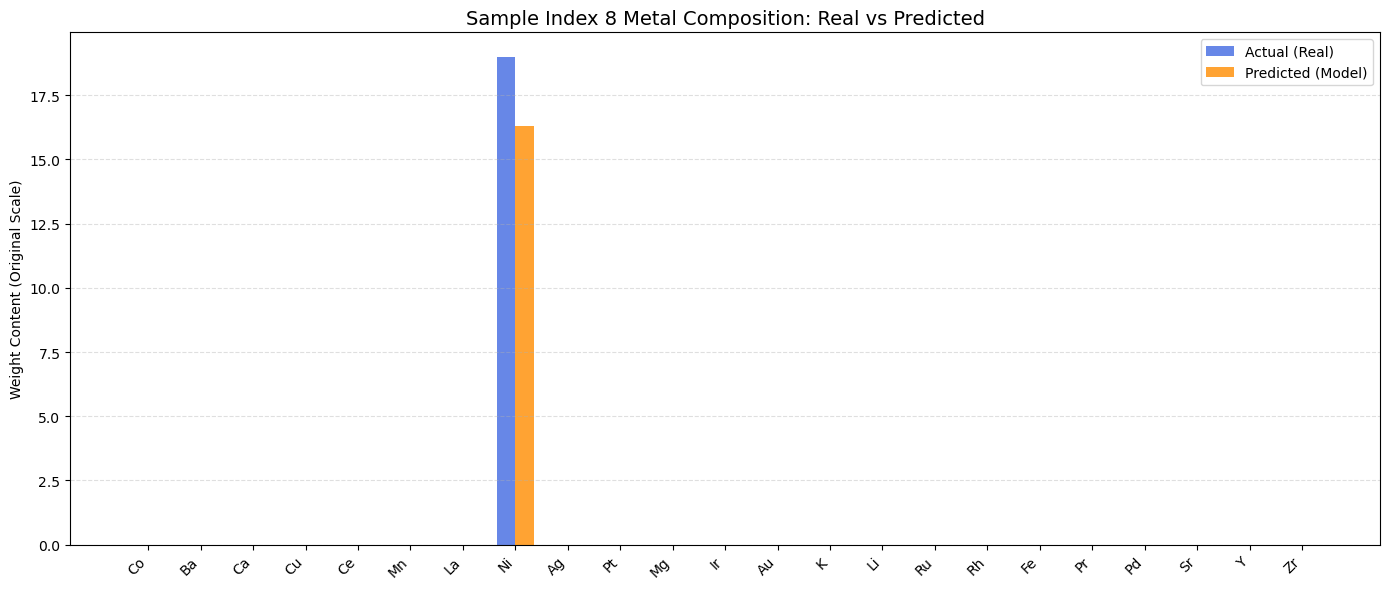

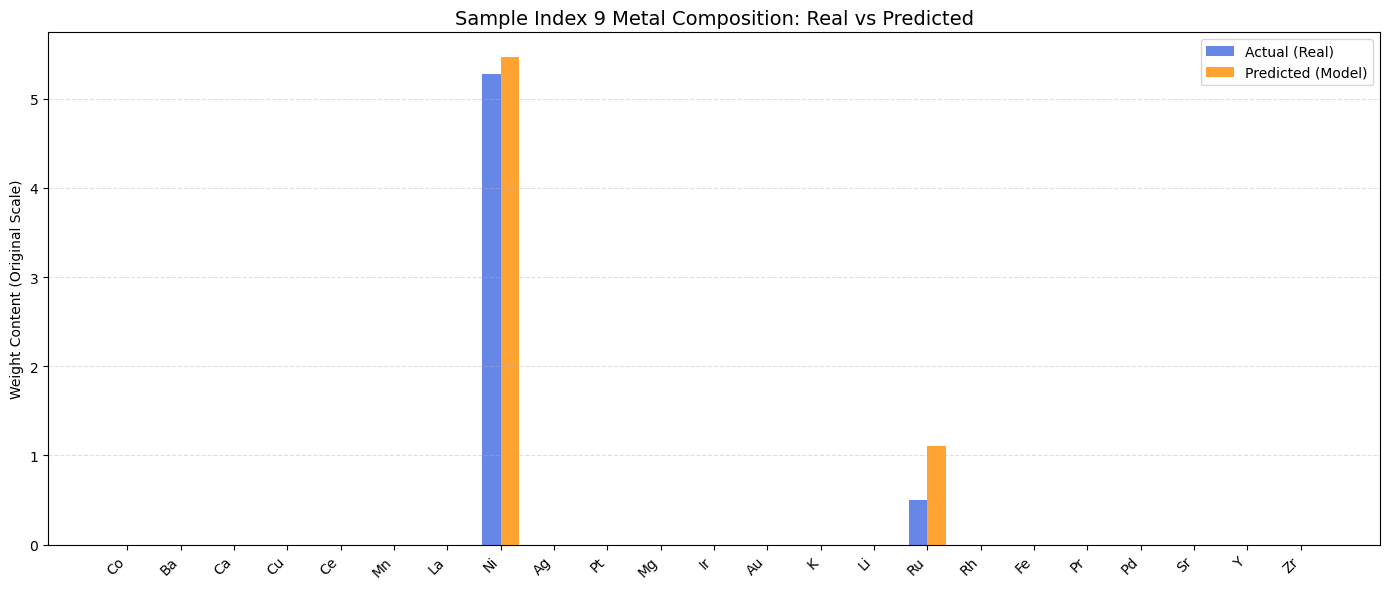

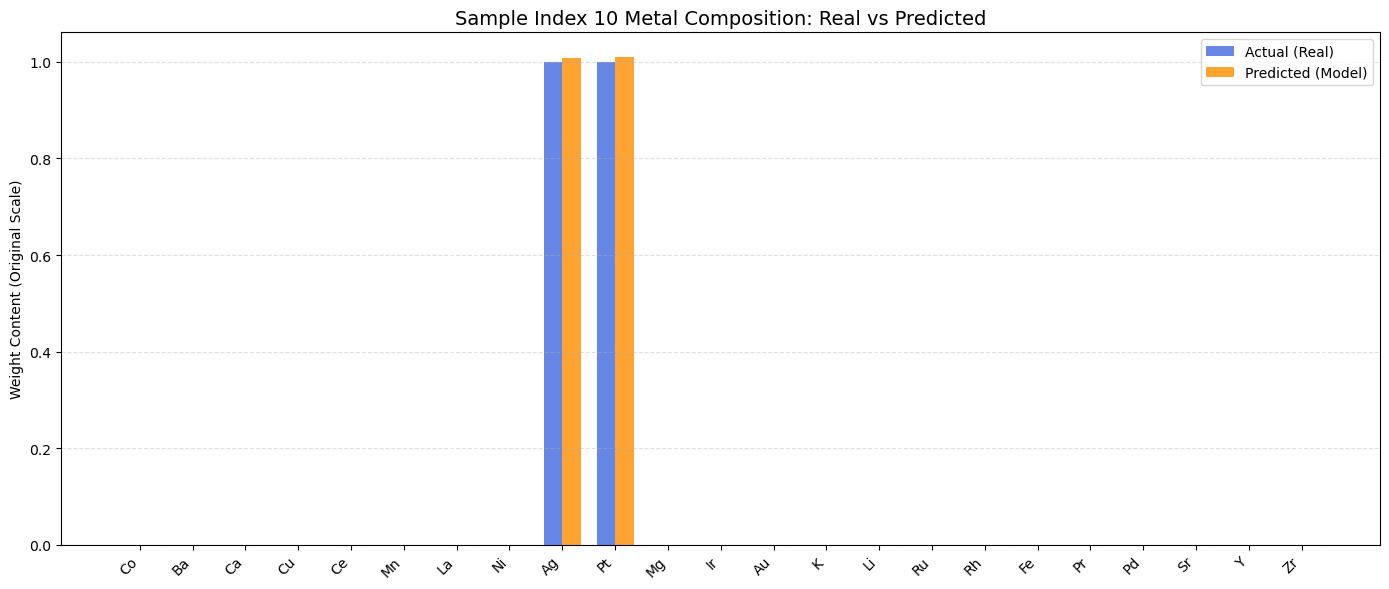

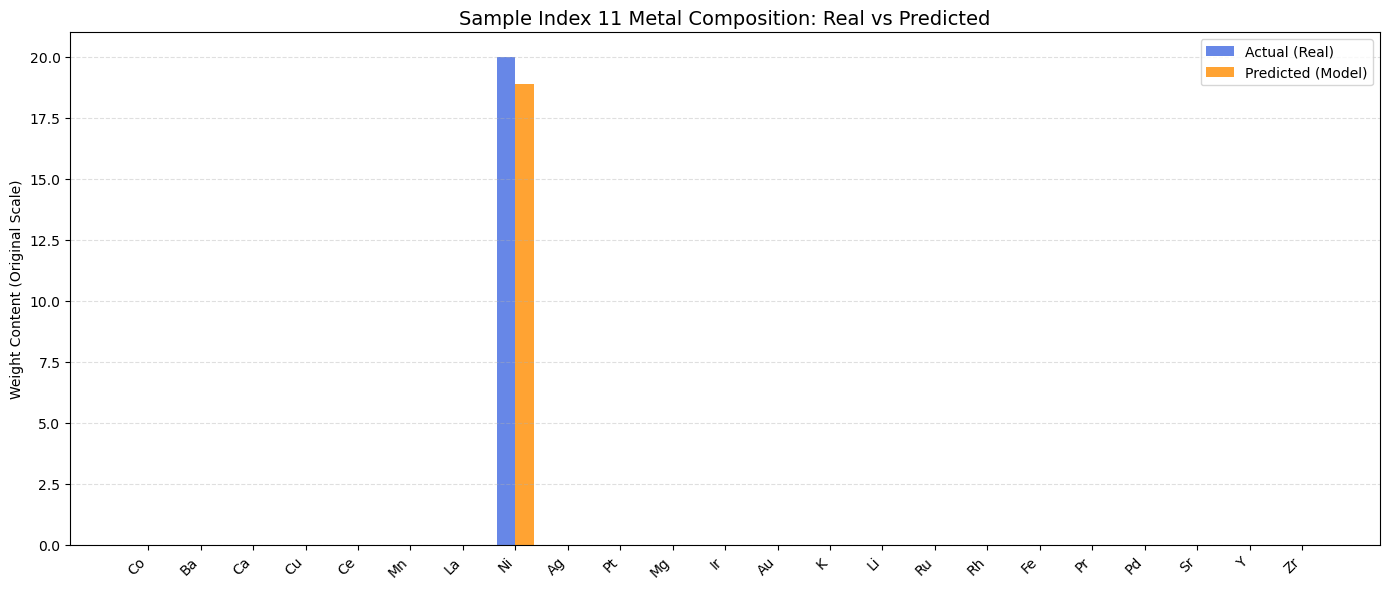

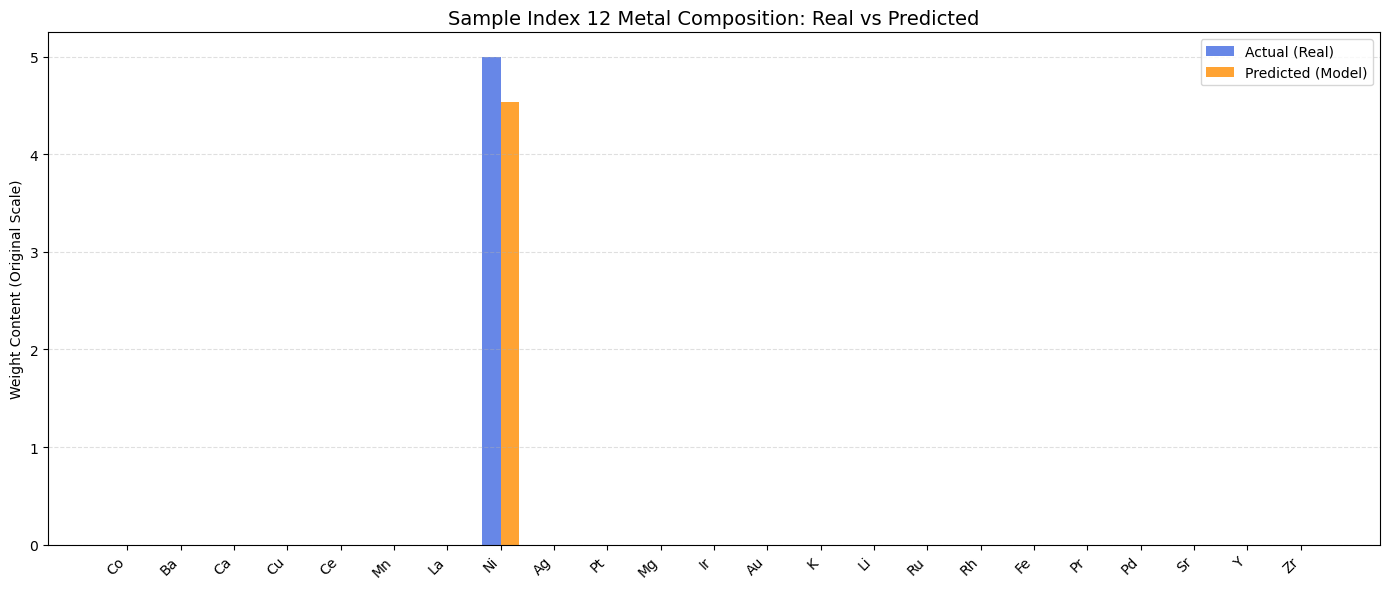

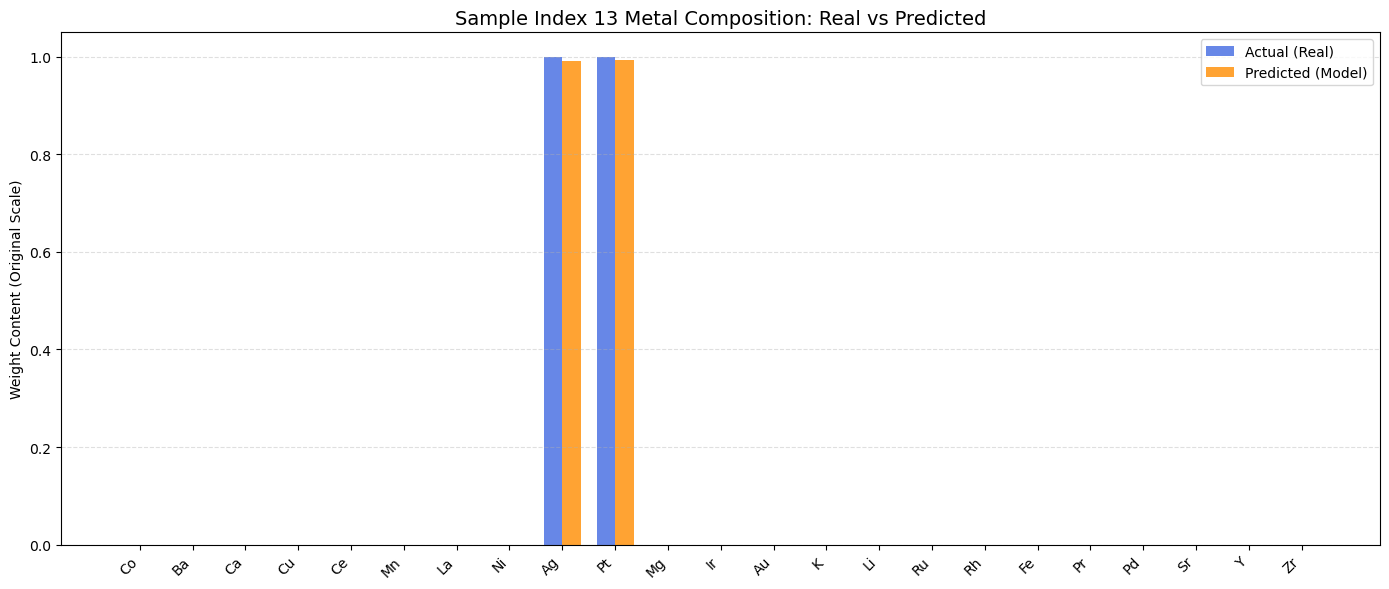

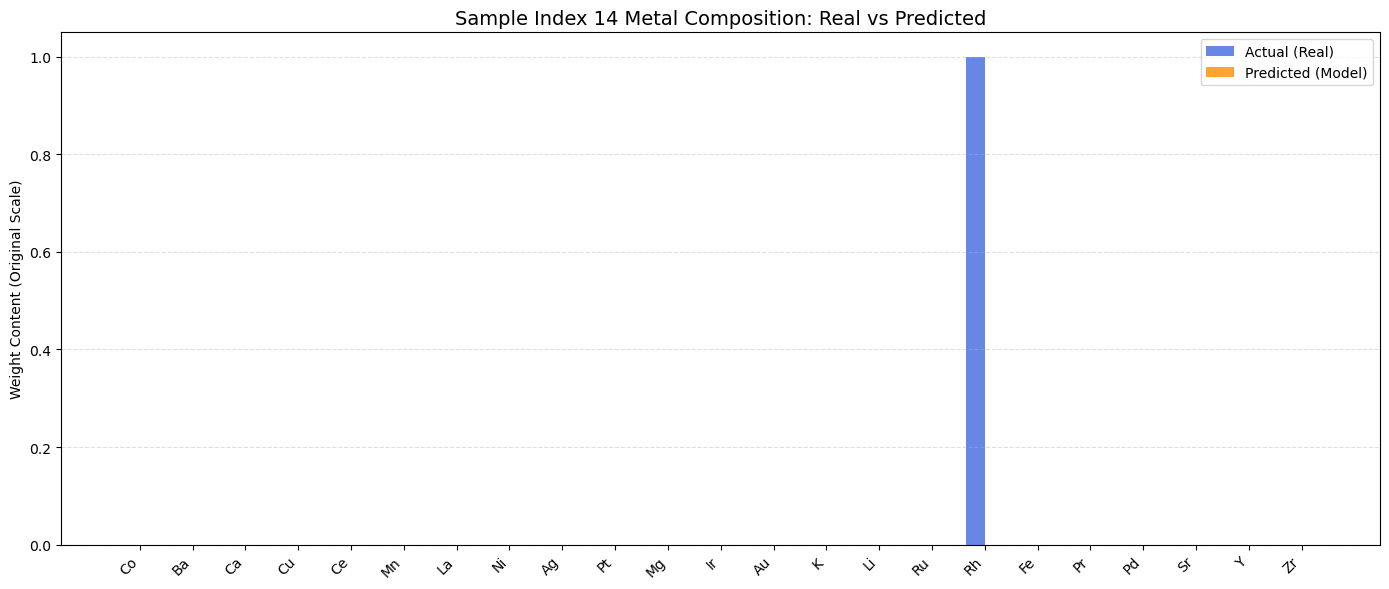

In [32]:
df_meta = pd.read_csv('211210-DRM-total.csv')
df_metal = df_meta.iloc[:,2:25]
metal_columns = df_metal.columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(23)
    width = 0.35
    
    plt.bar(x_axis - width/2,x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_hat_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()